# Environmental Effects on Beam Position Drift

## <font color='coral'>Introduction</font><a class="anchor" id="Intro"></a>

The electron beam in the Australian Synchrotron is as narrow as a human hair (322.9 micrometers). It orbits inside a vacuum chamber with a circumference of 215 meters and the narrow vacuum tube is only 6.4mm wide in some places, which is why the beam is programmatically constrained to a 1mm radius window transverse to it's orbital path. Beam stability within this window is important for many reasons including, instrumentation sensitivity, keeping radiation levels low and enabling consistent x-ray flux for our beamline research stations. 

The accelerator is made up of materials such as stainless steel and ceramics which are sensitive to thermal expansion, while coaxial cable (used to transfer signal to the beam position monitoring (BPM) instrumentation) is sensitive to moisture, and so small changes in environmental conditions can cause either the appearance of, or real shifts in the beam position relative to the BPMs.

The purpose of this analysis is to take existing data and learn as much as possible about the environmental cause (temperature vs humidity) and location (vacuum chamber vs coaxial cables vs signal processing instrumentation) of what is causing the beam to drift. Particularly, the question that I'm looking to answer is whether there is clear evidence to suggest that the electron beam can be further stabilised by adding environmental controls the server racks which house the BPM instrumentation.

### <font color='orange'>Content</font>
- [Introduction](#Intro)
- [Data Import](#DataImp)
    - [Load Data](#LoadData)
    - [Preview Data](#Prev)
- [Evaluate multicollinearity](#Multicollinearity)
- [Trim the LOCO Data](#Trim)
- [Resample Data](#Resample)
- [Time Lag Analysis](#Lag)

## <font color='coral'> Data Import & Cleaning</font><a class="anchor" id="DataImp"></a>

### <font color='orange'> Load data </font> <a class="anchor" id="LoadData"></a>

Unfortunately collection of this data is limited to periods where feedback systems can be turned off, this means any window greater than 24hrs is challenging to access and limits the natural environmental cycles that are observed as well. This will likely limit confidence in any findings made.

Environment data was provided in matlab files, loaded into numpy then joined into a dataframe.

In MATLAB® software, datenum representation is the number of days since midnight on Jan 1st, 0 AD.  Python's datetime.fromordinal function assumes time is the number of days since midnight on Jan 1st, 1 AD., so a conversion is also required below [using this method](https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python).

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

raw_data = loadmat('SR11_dataset.mat') #  Enter dataset name
sector = "SR11" # Enter dictionary key / sector

# temperature at Libera rack
# temp_rack_t (datenums):   [59100×1 double]
# temp_rack:                 [59100×1 double]
temp_rack = pd.DataFrame(np.concatenate((raw_data[sector][0][0][0],raw_data[sector][0][0][1]), axis = 1))
temp_rack = temp_rack.rename(columns={0: "temp_rack_t", 1: "temp_rack"})
# Convert from matlab datenum format
temp_rack['temp_rack_t'] = temp_rack['temp_rack_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
# Use the datenums as the index
temp_rack.set_index('temp_rack_t', inplace=True)

# temperature in accelerator enclosure, repeat same steps as above
# temp_tunnel_t (datenums): [2072×1 double]
# temp_tunnel:              [2072×1 double]
temp_tunnel = pd.DataFrame(np.concatenate((raw_data[sector][0][0][2],raw_data[sector][0][0][3]), axis = 1))
temp_tunnel = temp_tunnel.rename(columns={0: "temp_tunnel_t", 1: "temp_tunnel"})
temp_tunnel['temp_tunnel_t'] = temp_tunnel['temp_tunnel_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
temp_tunnel.set_index('temp_tunnel_t', inplace=True)

# humidity on tech floor, repeat same steps as above
# humidity_t (datenums):    [42042×1 double]
# humidity:                 [42042×1 double]  
humidity = pd.DataFrame(np.concatenate((raw_data[sector][0][0][4] ,raw_data[sector][0][0][5] ), axis = 1))
humidity = humidity.rename(columns={0: "humidity_t", 1: "humidity"})
humidity['humidity_t'] = humidity['humidity_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
humidity.set_index('humidity_t', inplace=True)

The circumference of the storage ring (where the electrons are held in a closed orbit with revolution frequency of 1.4 MHz) is divided into 14 sectors, each sector has seven vertical and horizontal position monitors. The orbit data is saved at a substantially higher rate than the environmental data (freq = 1.4MHz / period = 0.714μs), the beam position data provided has already been substantially down sampled using unknown methods.

The data provided is very much non tabular, the environment data and BPM data are different resolutions and every variable has it's own time series attached. The seven BPMs are all saved with a single time series and can be placed directly in a data frame together.

In [2]:
# horizontal position monitoring over seven bpms in the specified sector

# bpmx_t (datenums):  [154327×1 double]
# bpmx:               [154327×7 double]
bpmx = pd.concat([pd.DataFrame(data = raw_data[sector][0][0][8], columns = ['bpm_t']),pd.DataFrame(raw_data[sector][0][0][9])], axis = 1)
bpmx = bpmx.rename(columns={0: "bpm1", 
                            1: "bpm2", 
                            2: "bpm3", 
                            3: "bpm4", 
                            4: "bpm5", 
                            5: "bpm6", 
                            6: "bpm7",})
bpmx['bpm_t'] = bpmx['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmx.set_index('bpm_t', inplace=True)
bpmx.head()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-15 06:00:00.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2020-09-15 06:00:03.359125,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:06.718240,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:10.077364,0.0,0.0,0.045,0.0,0.0,0.0,0.0
2020-09-15 06:00:13.436489,0.0,0.0,-0.013,0.0,0.0,0.0,0.0


In [3]:
# vertical position monitoring over seven bpms in the specified sector

# bpmy_t (datenum):  [382179×1 double]
# bpmy:              [382179×7 double]
bpmy = pd.concat([pd.DataFrame(data = raw_data[sector][0][0][6], columns = ['bpm_t']),pd.DataFrame(raw_data[sector][0][0][7] )], axis = 1)
bpmy = bpmy.rename(columns={0: "bpm1", 
                            1: "bpm2", 
                            2: "bpm3", 
                            3: "bpm4", 
                            4: "bpm5", 
                            5: "bpm6", 
                            6: "bpm7",})
bpmy['bpm_t'] = bpmy['bpm_t'].apply(lambda matlab_datenum: datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366))
bpmy['bpm_t'] = pd.to_datetime(bpmy['bpm_t'])
bpmy.set_index('bpm_t', inplace=True)
bpmy.tail()

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
bpm_t,,,,,,,
2020-09-21 05:59:54.574260,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:55.930700,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:57.287130,1.049,0.108,NaN,-0.4,NaN,NaN,NaN
2020-09-21 05:59:58.643560,1.049,0.108,NaN,NaN,NaN,NaN,NaN
2020-09-21 06:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='orange'> Preview data </font><a class="anchor" id="Prev"></a>

Plot initial datasets and make sure there are no problems

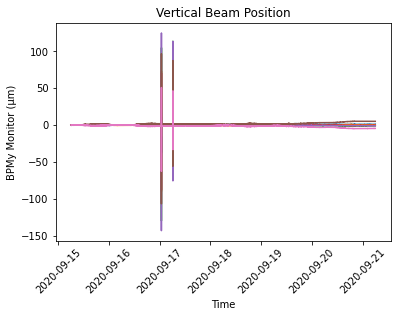

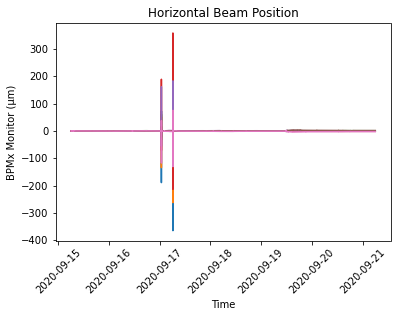

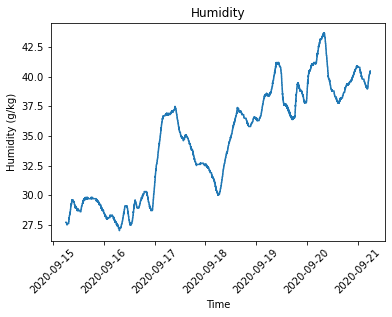

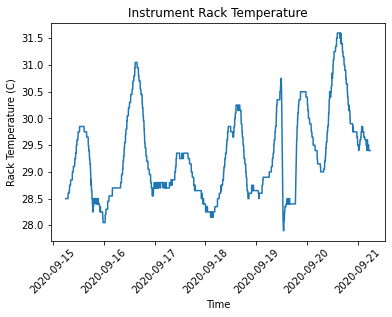

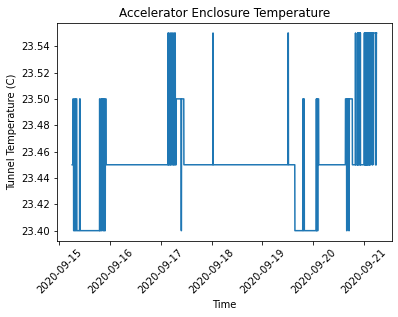

In [4]:
import matplotlib.pyplot as plt

plt.plot(bpmy)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(bpmx)
plt.title('Horizontal Beam Position')
plt.ylabel('BPMx Monitor (μm)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(humidity)
plt.title('Humidity')
plt.ylabel('Humidity (g/kg)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(temp_rack)
plt.title('Instrument Rack Temperature')
plt.ylabel('Rack Temperature (C)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.plot(temp_tunnel)
plt.title('Accelerator Enclosure Temperature')
plt.ylabel('Tunnel Temperature (C)')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

The low resolution of the Tunnel Temperature data may make it challenging to gain any helpful insight from this variable.

The beam position plots show large perturbations in the vertical and horizontal beam position, we need to determine whther this is faulty data or relating to real beam perturbations.

![Electron Orbit Studies](LOCO-interference.png)

If the perturbations are minimal, it's possible we could use outlier methods to remove the unwanted data:

<AxesSubplot:>

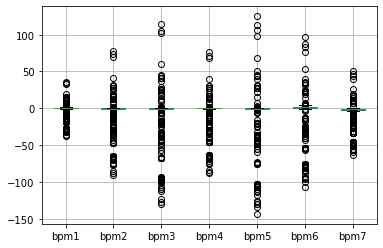

In [5]:
bpmy.boxplot()

Unfortunately, it appears the perturbations are extensive (more than just a couple of invalid data points), this needs a closer look.

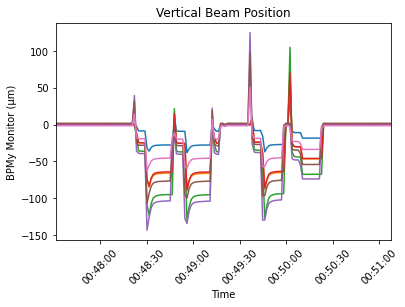

In [6]:
plt.plot(bpmy)
plt.title('Vertical Beam Position')
plt.ylabel('BPMy Monitor (μm)')
plt.xlabel('Time')
plt.xlim([18522.033, 18522.0355])
plt.xticks(rotation = 45)
plt.show()

Okay, perturbations following this pattern are typically caused during machine studies, when physicists need to measure the electron beam response to the magnets that control the beam positioning, this is referred to as a LOCO (Linear Optical from Closed Orbits) measurement. This data needs to be excluded, as the beam is not moving as a result of the environmental changes that we're trying to measure, but rather being driven by magnetic field changes. As this study is just a quick look at the data to determine it's potential, we'll simply crop the data down to exclude everything before the affected period of machine studies.

## <font color='coral'>Evaluate Multicollinearity</font><a class="anchor" id="Multicollinearity"></a>
We know there is generally a relationship between humidity and air temperature in the natural environment, that as the temperature drops humidity increases and vice versa. So first, before testing whether temperature or humidity are affecting the beam, we need to know how independent they are in this environment.

In [8]:
env = pd.concat([humidity.resample('5T').mean(),temp_rack.resample('5T').mean()], axis = 1)

In [9]:
env.corr()

,humidity,temp_rack
humidity,1.000000,0.299013
temp_rack,0.299013,1.000000


Low correlation between temperature and humidity, this is surprising but very possible given that the building has plenty of control over the environmental conditions. We'll plot these as well so we can be sure we haven't missed anything.

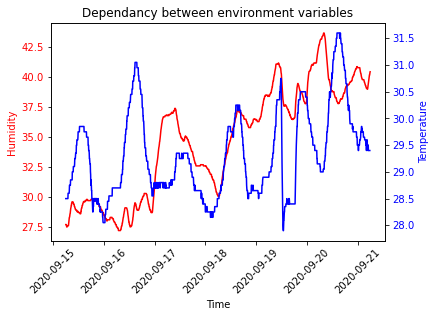

In [40]:
fig, ax1 = plt.subplots()

plt.xticks(rotation = 45)

ax1.set_xlabel('Time')
ax1.set_ylabel('Humidity', color='#ff0000')
ax1.plot(env.iloc[:, 0], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Temperature', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(env.iloc[:, 1], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

plt.title('Dependancy between environment variables')
#
plt.show()

It seem clear that for the most part that Temperature and Humidity do move independently. Although there certainly are times where the temperature and humidity do spike synchronously or inversely to one another. They seem more independent in the first half, particularly the 15th & 16th.

## <font color='coral'>Trim the LOCO data</font><a class="anchor" id="Trim"></a>
In this section:
- Trip LOCO data 
- Handle Nan's
- Match start and end times of beam and environment data

Run this to analyse the small segment of data before LOCO disturbance:

In [41]:
# bpmy has LOCO data between index 100000 - 130000
#Set sub-potion of data by start & end index
bpmy_end = 100000

# bpmx has bad data between 50000 - 51800
#Set sub-potion of data by start & end index
bpmx_end = 50000

# Drop Nans and trim loco data
bpmy_trim = bpmy.iloc[:bpmy_end].dropna()
bpmx_trim = bpmx.iloc[:bpmx_end].dropna()
temp_rack_trim = temp_rack.dropna()
temp_tunnel_trim = temp_tunnel.dropna()
humidity_trim = humidity.dropna()

bpmy_trim.iloc[1:6,1:3]

,bpm2,bpm3
bpm_t,,
2020-09-15 06:00:01.356440,0.000,0.000
2020-09-15 06:00:02.712870,0.000,0.045
2020-09-15 06:00:04.069300,0.000,0.045
2020-09-15 06:00:05.425740,0.000,0.045
2020-09-15 06:00:06.782180,-0.004,0.045


Or run this for the larger segment of data after the LOCO measurement

In [42]:
# bpmy has LOCO data between 100000 - 130000
#Set sub-potion of data by start & end index
#bpmy_start = 130000 

# bpmx has bad data between 50000 - 51800
# Set sub-potion of data by start & end index
#bpmx_start = 51800 

# Drop Nans and trim loco data
#bpmy_trim = bpmy.iloc[bpmy_start:].dropna()
#bpmx_trim = bpmx.iloc[bpmx_start:].dropna()
#temp_rack_trim = temp_rack.dropna()
#temp_tunnel_trim = temp_tunnel.dropna()
#humidity_trim = humidity.dropna()

Having seen the results, the longer timeframe above adds complexity to understanding the problem and isn't helpful for initial findings. But it is interesting to see once the findings are understood. Feel free to uncomment and run the notebook from this section once you reach the end.

The beam data and environment data don't cover the exact same time periods, this is matched up here by trimming all datasets to the same time interval.

In [43]:
# Truncate each dataset on upper and lower bounds of each dataset

upper_bound = np.array([bpmy_trim.index.values.max(),
                        bpmx_trim.index.values.max(),
                        temp_rack_trim.index.values.max(),
                        temp_tunnel_trim.index.values.max(),
                        humidity_trim.index.values.max()
                        ]).min()

lower_bound = np.array([bpmy_trim.index.values.min(),
                        bpmx_trim.index.values.min(),
                        temp_rack_trim.index.values.min(),
                        temp_tunnel_trim.index.values.min(),
                        humidity_trim.index.values.min()
                        ]).max()

bpmy_trim = bpmy_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
bpmx_trim = bpmx_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
temp_rack_trim = temp_rack_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
temp_tunnel_trim = temp_tunnel_trim.truncate(before=lower_bound, after=upper_bound, axis =0)
humidity_trim = humidity_trim.truncate(before=lower_bound, after=upper_bound, axis =0)

## <font color='coral'>Resample Data</font><a class="anchor" id="Resample"></a>
The number of data points in each dataset is different, the beam data particularly is sampled at a higher frequency that the environmental data. Each variable is re-sampled so that the timing intervals of both datasets match and can be used in a tabular format. The resample method uses the the mean value within a 5 minute window.

In [44]:
bpmx_resample = bpmx_trim.resample('5T').mean()
bpmy_resample = bpmy_trim.resample('5T').mean()
temp_tunnel_resample = temp_tunnel_trim.resample('5T').mean()
humidity_resample = humidity_trim.resample('5T').mean()
temp_rack_resample = temp_rack_trim.resample('5T').mean()

## <font color='coral'> Visualise Synchrony </font> <a class="anchor" id="Visualise"></a>
Now that all our data is synchronised in a tabular format, it can be overlaid in a single plot.

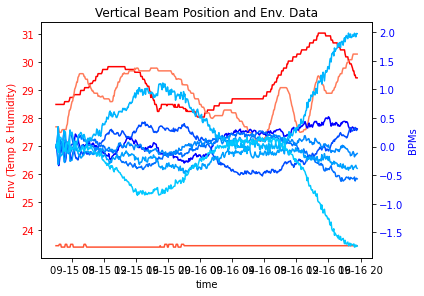

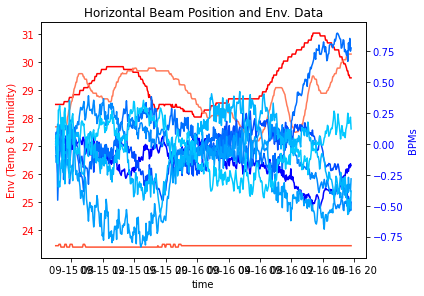

In [45]:
from matplotlib import cm

# One plot to overlay zoomed component, for time correlation estimate
all_y = pd.concat([bpmy_resample, temp_rack_resample, temp_tunnel_resample, humidity_resample], axis=1).dropna()
all_x = pd.concat([bpmx_resample, temp_rack_resample, temp_tunnel_resample, humidity_resample], axis=1).dropna()


# yplot
#############################

fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color='#ff0000')
ax1.plot(all_y.iloc[:, 7], color='#ff0000')
ax1.plot(all_y.iloc[:, 8], color='#ff5232')
ax1.plot(all_y.iloc[:, 9], color='#ff7b5a')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPMs', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 0], color='#0000ff')
ax2.plot(all_y.iloc[:, 1], color='#004cff')
ax2.plot(all_y.iloc[:, 2], color='#006eff')
ax2.plot(all_y.iloc[:, 3], color='#0089ff')
ax2.plot(all_y.iloc[:, 4], color='#00a0ff')
ax2.plot(all_y.iloc[:, 5], color='#00b5ff')
ax2.plot(all_y.iloc[:, 6], color='#02c8ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Vertical Beam Position and Env. Data')
plt.show()

# xplot
##################################

fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('Env (Temp & Humidity)', color='#ff0000')
ax1.plot(all_x.iloc[:, 7], color='#ff0000')
ax1.plot(all_x.iloc[:, 8], color='#ff5232')
ax1.plot(all_x.iloc[:, 9], color='#ff7b5a')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('BPMs', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_x.iloc[:, 0], color='#0000ff')
ax2.plot(all_x.iloc[:, 1], color='#004cff')
ax2.plot(all_x.iloc[:, 2], color='#006eff')
ax2.plot(all_x.iloc[:, 3], color='#0089ff')
ax2.plot(all_x.iloc[:, 4], color='#00a0ff')
ax2.plot(all_x.iloc[:, 5], color='#00b5ff')
ax2.plot(all_x.iloc[:, 6], color='#02c8ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Horizontal Beam Position and Env. Data')
plt.show()

It's a bit difficult to see with all the Beam Position Monitors (BPMs) in a single colour, but it appears as though there will be a high correlation between one of out env parameters and the vertical beam positions, some will negatively correlate while others will positively correlate.

Below we filter some variables to show that relationship symmetry more clearly.

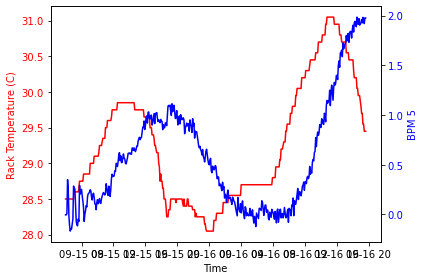

In [46]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Rack Temperature (C)', color='#ff0000')
ax1.plot(all_y.iloc[:, 7], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPM 5', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 5], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Interestingly, there appears to be a time lag, although the positive correlation symmetry is very clear.

A second example below:

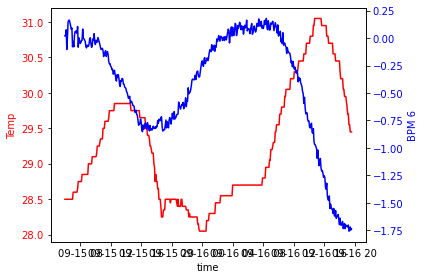

In [47]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('Temp', color='#ff0000')
ax1.plot(all_y.iloc[:, 7:8], color='#ff0000')
ax1.tick_params(axis='y', labelcolor='#ff0000')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('BPM 6', color='#0000ff')  # we already handled the x-label with ax1
ax2.plot(all_y.iloc[:, 6:7], color='#0000ff')
ax2.tick_params(axis='y', labelcolor='#0000ff')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In this instance we see symmetry which we expect to show a strong negative correlation.

Initial unadjusted correlation coefficient (R):

In [48]:
all_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,-0.849556,0.159646,0.622692,-0.304426,-0.595378,-0.227389,0.208214
temp_tunnel,-0.170410,0.132310,0.113994,-0.468094,0.484465,0.247078,-0.377628
humidity,-0.042746,-0.677070,0.411740,-0.052092,-0.645185,-0.703049,0.639257


In [49]:
all_y.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]


,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,0.641033,0.013379,-0.545885,-0.041121,0.104830,0.457443,-0.531827
temp_tunnel,0.215789,-0.285633,0.140665,0.253268,-0.144130,0.006059,0.018134
humidity,-0.153559,0.735598,-0.729412,-0.644870,-0.467447,0.692394,-0.687949


There are clearly elements of correlation between the beam position on each BPM and each env factor. Some BPMs appear to have higher correlation with humidity than temperature, which is not entirely unexpected.

Below we scatter plot each BPM againts each environmental monitor.

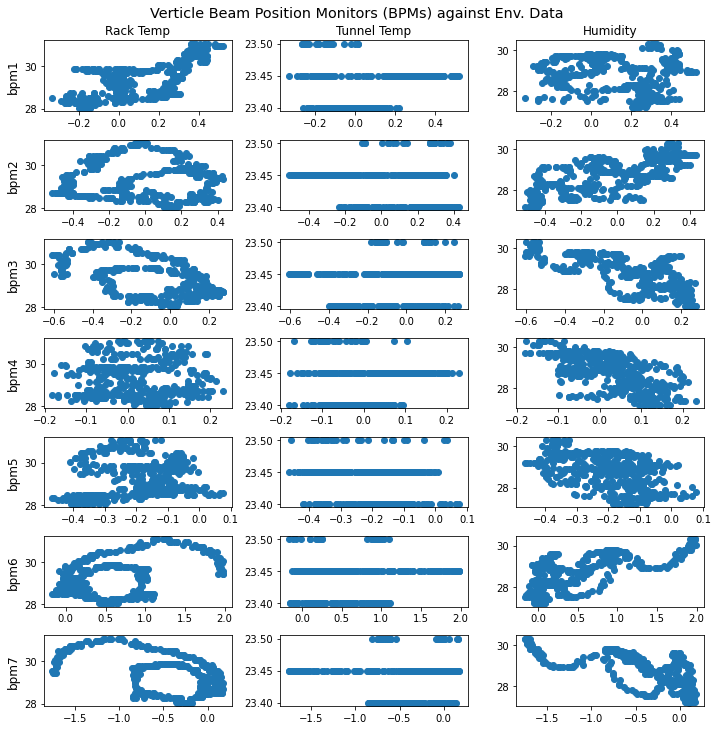

In [50]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_y[rows[i]],all_y['temp_rack'])
    axes[i][1].scatter(all_y[rows[i]],all_y['temp_tunnel'])
    axes[i][2].scatter(all_y[rows[i]],all_y['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Verticle Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

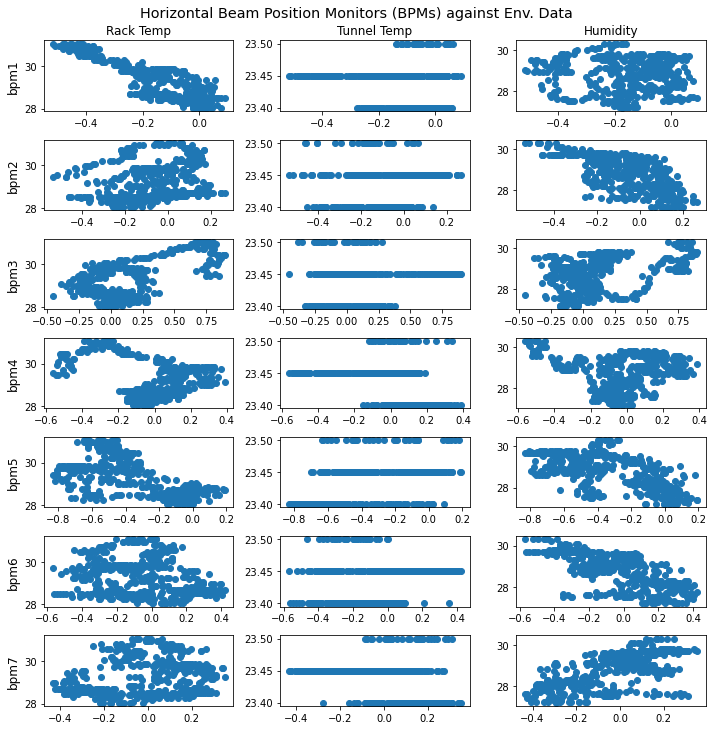

In [51]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['Rack Temp','Tunnel Temp','Humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(all_x[rows[i]],all_x['temp_rack'])
    axes[i][1].scatter(all_x[rows[i]],all_x['temp_tunnel'])
    axes[i][2].scatter(all_x[rows[i]],all_x['humidity'])

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
fig.suptitle("Horizontal Beam Position Monitors (BPMs) against Env. Data", fontsize="x-large",  y=1.01)
plt.show()

## <font color='coral'> Time Lag Analysis </font><a class="anchor" id="Lag"></a>

We noticeded above there was a time lag between cause (environment change) and effect (beam position drift), we need to know how long this lag is and add an offset to the data so that we can obtain better correlation estimates.

![time Lag](time-lag.png)

It's unclear why there is a time lag, it could be related to poor air flow around the temperature monitoring, or any number of other reasons. This will be a consideration for future improvements if this work continues.

Below we compare the distance between peaks in the data, to estimate how long the lag period is:

In [52]:
# maximum lag interval
max_lag = (all_y.iloc[:, 7][all_y.iloc[:, 7] == max(all_y.iloc[:, 7])].index.values[0] - all_y.iloc[:, 5][all_y.iloc[:, 5] == max(all_y.iloc[:, 5])].index.values[0]).astype('timedelta64[m]')

# minimum lag interval
min_lag = (all_y.iloc[:, 7][all_y.iloc[:, 7] == max(all_y.iloc[:, 7])].index.values[10] - all_y.iloc[:, 5][all_y.iloc[:, 5] == max(all_y.iloc[:, 5])].index.values[0]).astype('timedelta64[m]')

print("Time lag is estimated to be approximately between ", min_lag, " and ", max_lag)

Time lag is estimated to be approximately between  -175 minutes  and  -225 minutes


Since the lag falls within an estimated 50 minute window, we'll calculate the correlation constant for that time range and identify the precise lag by indexing the time at which the correlation constant is maximised for all BPMs.

Below the, the correlation constant is calculated for lag between 0 and 200 minutes and then plotted:

In [53]:
cor_lag_y = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_y)-1):
    data_bpms = all_y.iloc[0+i:len(all_y),:]
    data_env = all_y.iloc[0:len(all_y)-i,:]
    data = pd.concat([data_bpms.iloc[:,0:7].reset_index(), data_env.iloc[:,7:10].reset_index()], axis = 1)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_y = np.vstack((cor_lag_y, cor.values.flatten()))

cor_lag_x = np.zeros(shape=(1,21))

# Removetail from BPMs and head from env data, as we anticipate that rack temp will preceed bpm effects
for i in range(0,len(all_x)-1):
    data_bpms = all_x.iloc[0+i:len(all_x),:]
    data_env = all_x.iloc[0:len(all_x)-i,:]
    data = pd.concat([data_bpms.iloc[:,0:7].reset_index(), data_env.iloc[:,7:10].reset_index()], axis = 1)
    cor = data.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]
    cor_lag_x = np.vstack((cor_lag_x, cor.values.flatten()))

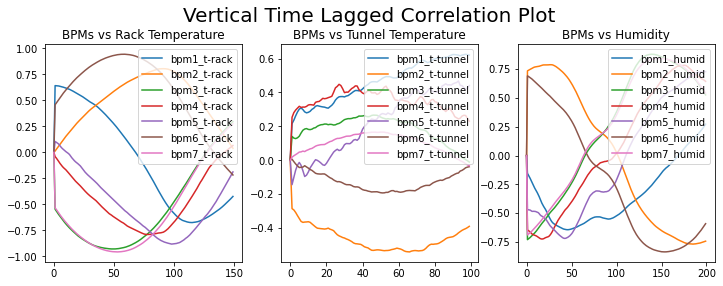

In [54]:
# Y TLCC correlation plots

cor_lag_y = pd.DataFrame(cor_lag_y)
cor_lag_y.columns = ['bpm1_t-rack', 
              'bpm2_t-rack',
              'bpm3_t-rack',
              'bpm4_t-rack',
              'bpm5_t-rack',
              'bpm6_t-rack',
              'bpm7_t-rack',
             'bpm1_t-tunnel', 
              'bpm2_t-tunnel',
              'bpm3_t-tunnel',
              'bpm4_t-tunnel',
              'bpm5_t-tunnel',
              'bpm6_t-tunnel',
              'bpm7_t-tunnel',
             'bpm1_humid', 
              'bpm2_humid',
              'bpm3_humid',
              'bpm4_humid',
              'bpm5_humid',
              'bpm6_humid',
              'bpm7_humid']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_y.iloc[0:150,0:7])
axes[0].legend(list(cor_lag_y.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_y.iloc[0:100:,7:14])
axes[1].legend(list(cor_lag_y.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_y.iloc[0:200,14:21])
axes[2].legend(list(cor_lag_y.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('Vertical Time Lagged Correlation Plot', fontsize=20, y=1.01)

fig.set_figwidth(12)

plt.show()

These are very unexpected results!

#### Rack Temperature Correlation:
Each BPM appears to have differing lag times! That was not expected. The most highly correlated BPMs (BPM 3, 6 & 7) are almost perfectly correlated at index/x-axis = 50, each data row corresponds to 5 minutes, so the lag period = 50 x 5 = 250mins = 4hrs. BPMs which correlate less also have a more delayed effect

#### Tunnel Temperature Correlation:
Shows similar lag to the Rack Temperatures. If anything a fraction more delayed and less highly correlated - this could be explained by the fact that the tunnels pump in air from the Tech Hall (where the racks are located) which is conditioned on the way in.

#### Humidity
It's difficult to tell whether this impact is more immediate or more delayed. Correlation at the 150 mark is highest, but it's clear that there is a peak at the 25 mark as well. It's possible that there are two modes by which the humidity can influence the beam position, one which is more delayed than another, or related to the multicollinearity between temperature & humidity.

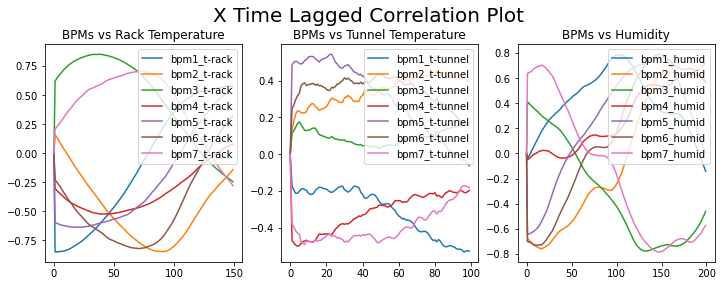

In [55]:
# X TLCC correlation plots

cor_lag_x = pd.DataFrame(cor_lag_x)
cor_lag_x.columns = ['bpm1_t-rack', 
              'bpm2_t-rack',
              'bpm3_t-rack',
              'bpm4_t-rack',
              'bpm5_t-rack',
              'bpm6_t-rack',
              'bpm7_t-rack',
             'bpm1_t-tunnel', 
              'bpm2_t-tunnel',
              'bpm3_t-tunnel',
              'bpm4_t-tunnel',
              'bpm5_t-tunnel',
              'bpm6_t-tunnel',
              'bpm7_t-tunnel',
             'bpm1_humid', 
              'bpm2_humid',
              'bpm3_humid',
              'bpm4_humid',
              'bpm5_humid',
              'bpm6_humid',
              'bpm7_humid']

fig, axes= plt.subplots(nrows=1, ncols=3)

axes[0].set_title('BPMs vs Rack Temperature')
axes[0].plot(cor_lag_x.iloc[0:150,0:7])
axes[0].legend(list(cor_lag_x.iloc[:,0:7].columns), loc = 'upper right')


axes[1].set_title('BPMs vs Tunnel Temperature')
axes[1].plot(cor_lag_x.iloc[0:100,7:14])
axes[1].legend(list(cor_lag_x.iloc[:,7:14].columns), loc = 'upper right')


axes[2].set_title('BPMs vs Humidity')
axes[2].plot(cor_lag_x.iloc[0:200,14:21])
axes[2].legend(list(cor_lag_x.iloc[:,14:21].columns), loc = 'upper right')

fig.suptitle('X Time Lagged Correlation Plot', fontsize=20, y=1.01)

fig.set_figwidth(12)

plt.show()

The horizontal beam effects are very much similar to the vertical effects, although there appears to be high variance on this axis.

## <font color='blue'> Quantify time lag and apply it </font>

The table below grabs the peak correlation index for each BPM and env factor.

In [56]:
# delay is simply quantified by the index of the data

delay_track_y = cor_lag_y.iloc[0:150,0:7].abs().idxmax()
delay_track_y = delay_track_y.reset_index()[0]

delay_ttunnel_y = cor_lag_y.iloc[0:100,7:14].abs().idxmax()
delay_ttunnel_y = delay_ttunnel_y.reset_index()[0]

delay_humid_y = cor_lag_y.iloc[0:200,14:21].abs().idxmax()
delay_humid_y = delay_humid_y.reset_index()[0]

delay_track_x = cor_lag_x.iloc[0:150,0:7].abs().idxmax()
delay_track_x = delay_track_x.reset_index()[0]

delay_ttunnel_x = cor_lag_x.iloc[0:100,7:14].abs().idxmax()
delay_ttunnel_x = delay_ttunnel_x.reset_index()[0]

delay_humid_x = cor_lag_x.iloc[0:200,14:21].abs().idxmax()
delay_humid_x = delay_humid_x.reset_index()[0]

delay_y = pd.DataFrame({
    'temp_rack_x': delay_track_x,
    'temp_rack_y': delay_track_y,
    'temp_tunnel_x': delay_ttunnel_x,
    'temp_tunnel_y': delay_ttunnel_y,
    'humidity_x': delay_humid_x,
    'humidity_y': delay_humid_y
})
delay_y = delay_y.T
delay_y.columns = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
delay_y

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack_x,2,90,38,40,22,70,71
temp_rack_y,115,91,50,77,98,59,53
temp_tunnel_x,96,81,5,4,22,49,8
temp_tunnel_y,97,66,46,27,93,51,51
humidity_x,102,16,133,177,149,146,148
humidity_y,46,27,139,175,197,154,150


BPM 3, 6 and 7 seemed most sensitive to rack temperature fluctuations, so we're going to apply the average lag for those monitors to all (for lack of a better idea). With more time, we'd try to access a longer period of data, as the 37hrs we have is looking insufficient for this problem.

## <font color=blue>Set Delay</font>
We have assumed that the same delay should be applied to every bpm for each env variable

In [57]:
# Manually apply delay, x and y seem to require the same delays
d_track_x = 47 
d_track_y = 58

d_ttunnel_x = 50
d_ttunnel_y = 27

d_humid_y = 199
d_humid_x = 120

max_d = np.array([d_track_x, d_track_y ,d_ttunnel_x, d_ttunnel_y, d_humid_x, d_humid_y]).max()

# synchronise X dataset
synch_x = all_x
synch_x.temp_rack = all_x.temp_rack.shift(d_track_x)
synch_x.temp_tunnel = all_x.temp_tunnel.shift(d_ttunnel_x)
synch_x.humidity = all_x.humidity.shift(d_humid_x)

synch_x = synch_x.dropna()

# synchronise Y dataset
synch_y = all_y
synch_y.temp_rack = all_y.temp_rack.shift(d_track_y)
synch_y.temp_tunnel = all_y.temp_tunnel.shift(d_ttunnel_y)
synch_y.humidity = all_y.humidity.shift(d_humid_y)

synch_y = synch_y.dropna()

synch_y

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7,temp_rack,temp_tunnel,humidity
2020-09-15 22:35:00,-0.209869,0.270176,-0.100140,0.053118,-0.398511,0.736869,-0.429710,28.95,23.50,27.700000
2020-09-15 22:40:00,-0.252063,0.263742,-0.038005,0.013054,-0.405471,0.692403,-0.381009,28.75,23.50,27.700000
2020-09-15 22:45:00,-0.218330,0.230995,-0.038579,0.015511,-0.374380,0.671122,-0.373706,28.85,23.50,27.700000
2020-09-15 22:50:00,-0.196779,0.229365,-0.056423,0.046437,-0.398667,0.685486,-0.374649,28.75,23.50,27.700000
2020-09-15 22:55:00,-0.215769,0.217688,-0.021041,-0.034602,-0.336294,0.650493,-0.381104,28.75,23.40,27.650000
...,...,...,...,...,...,...,...,...,...,...
2020-09-16 19:15:00,0.285855,0.302959,-0.531950,-0.178249,-0.358638,1.982665,-1.756959,30.80,23.45,28.100000
2020-09-16 19:20:00,0.300407,0.335063,-0.600172,-0.137679,-0.342462,1.963027,-1.751950,30.80,23.45,28.100000
2020-09-16 19:25:00,0.317380,0.296000,-0.564213,-0.145801,-0.326077,1.920050,-1.718882,30.95,23.45,28.154167
2020-09-16 19:30:00,0.318195,0.282357,-0.553579,-0.132054,-0.370416,1.978041,-1.745710,30.95,23.45,28.258333


## <font color=blue>Analysis of synchronised data</font>

Measure R after synchronisation of data

In [58]:
synch_y.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,0.499125,0.705143,-0.950948,-0.784721,-0.565156,0.953784,-0.966227
temp_tunnel,-0.066101,0.038547,0.002333,0.036797,-0.061314,-0.002853,0.012184
humidity,0.284514,-0.738893,0.513639,0.635419,0.728708,-0.578578,0.529631


In [59]:
synch_x.corr().loc[['temp_rack', 'temp_tunnel', 'humidity'],['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']]

,bpm1,bpm2,bpm3,bpm4,bpm5,bpm6,bpm7
temp_rack,-0.463922,-0.571769,0.836742,-0.581390,-0.710334,-0.795135,0.743371
temp_tunnel,-0.362030,0.444836,0.047615,-0.305851,0.313523,0.475087,-0.514565
humidity,0.657170,0.192131,-0.716364,0.429817,0.689381,0.578225,-0.579217


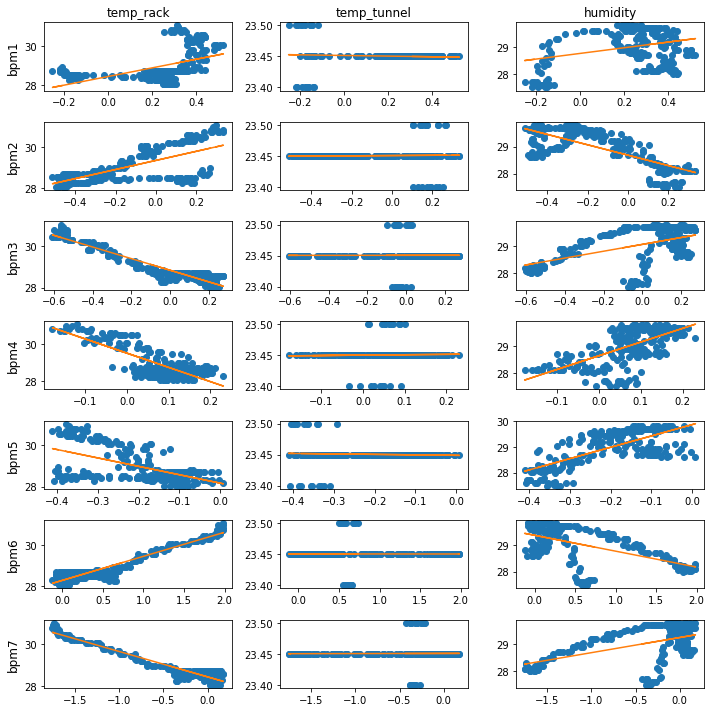

In [60]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_y[rows[i]],synch_y['temp_rack'])
    b, m = polyfit(synch_y[rows[i]], synch_y['temp_rack'], 1)
    axes[i][0].plot(synch_y[rows[i]], synch_y['temp_rack'], '.')
    axes[i][0].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')
    
    
    axes[i][1].scatter(synch_y[rows[i]],synch_y['temp_tunnel'])
    b, m = polyfit(synch_y[rows[i]], synch_y['temp_tunnel'], 1)
    axes[i][1].plot(synch_y[rows[i]], synch_y['temp_tunnel'], '.')
    axes[i][1].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')
    
    axes[i][2].scatter(synch_y[rows[i]],synch_y['humidity'])
    b, m = polyfit(synch_y[rows[i]], synch_y['humidity'], 1)
    axes[i][2].plot(synch_y[rows[i]], synch_y['humidity'], '.')
    axes[i][2].plot(synch_y[rows[i]], b + m * synch_y[rows[i]], '-')    
    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

It's clear that correlation with rack temperatures is very high, but there is an unexpected divergence on some BPMs where a different correlation constant would fit. This could be caused by many factors, automatic gain control on the instrument could have changed, or an orbit correction could have moved the beam position. New data will be required to be collected with tight experimental controls to eliminate these possibilities, or the gain correction could be subtracted from the data - this could be challenging though.

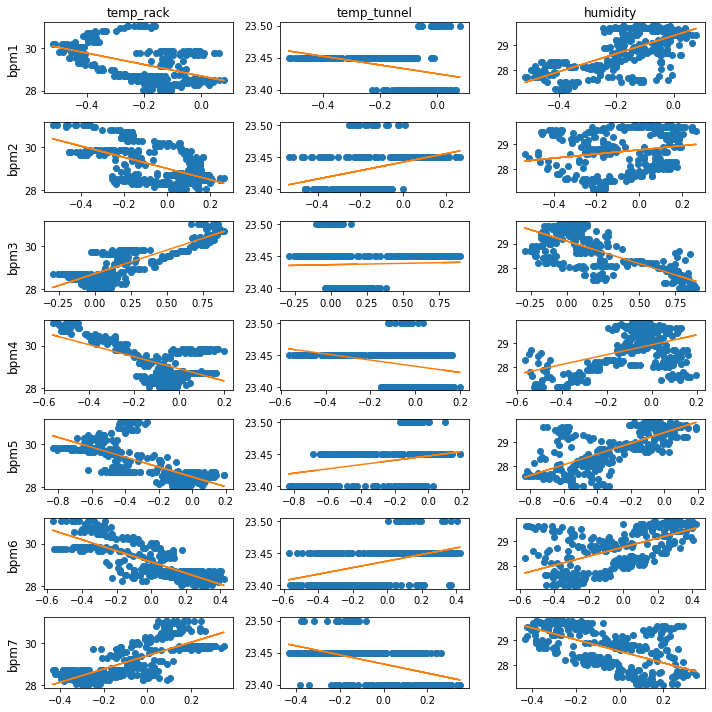

In [61]:
import matplotlib.pyplot as plt

# Subplot formatting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 10))

# Col and row lables
rows = ['bpm1', 'bpm2', 'bpm3', 'bpm4', 'bpm5', 'bpm6', 'bpm7']
cols = ['temp_rack','temp_tunnel','humidity']

# Fill plots with data
for i in range(7):
    axes[i][0].scatter(synch_x[rows[i]],synch_x['temp_rack'])
    b, m = polyfit(synch_x[rows[i]], synch_x['temp_rack'], 1)
    axes[i][0].plot(synch_x[rows[i]], synch_x['temp_rack'], '.')
    axes[i][0].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')   
    
    axes[i][1].scatter(synch_x[rows[i]],synch_x['temp_tunnel'])
    b, m = polyfit(synch_x[rows[i]], synch_x['temp_tunnel'], 1)
    axes[i][1].plot(synch_x[rows[i]], synch_x['temp_tunnel'], '.')
    axes[i][1].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')    
    
    axes[i][2].scatter(synch_x[rows[i]],synch_x['humidity'])
    b, m = polyfit(synch_x[rows[i]], synch_x['humidity'], 1)
    axes[i][2].plot(synch_x[rows[i]], synch_x['humidity'], '.')
    axes[i][2].plot(synch_x[rows[i]], b + m * synch_x[rows[i]], '-')    

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.show()

Lower correlation on the horizontal axis, but there is still clearly an impact from environment fluctuations.

# <font color=blue> KEY LEARNING:</font>
- There are very high correlations between rack temperature fluctuations and the beam position drift
- The effect seems most aligned with the temperatures measured in the instrument racks
- Correlation with humidity and tunnel temperatures are less obvious for reasons discussed throughout the notebook
- The impact of temperature fluctuations on each BPM seems to vary, some are more impacted than others and have independent delay periods.
- There is substantial multicollinearity between humidity and both temperature measures, these cannot be assessed independently.
- Higher resolution for tunnel temperature data is needed
- Whilst temperature correlation is strong, it is not the only force at play.

# <font color=blue> FUTURE IMPROVEMENTS:</font>
- Experiments during which the humidity and temperature in the accelerator enclosure and the instrument racks are controlled independently would improve knowledge of the source of the problem.
- Collecting data over longer periods of time (more environment fluctuations) would also help to assess the correlations more accurately
- Further developing functions which request data directly from the archive appliance and assess any/all positions across the accelerator would help improve results as well.

# <font color=blue> ACCELERATOR PARAMETERS REQUIRED FOR FURTHER DATA COLLECTION:</font>
The following operational parameters may have impacted the data collected for this analysis, they need to be controlled in the next round of data collection:
- Turn all instrument (Libera) auto-gain controls off
- Insertion devices must be withdrawn and disabled
- Orbit feedbacks must be disabled, preventing unwanted corrections to the beam position

# <font color=blue> FURTHER QUESTIONS:</font>
- Perhaps LCW (Cooling water) would provide better tunnel temperature than the thermocouple data supplied?
- Alternative cause may be that LCW (cooling water) could be causing the voltage/current of the Magnet Power Supplies to drifts, causing real shifts in the beam rather than perceived ones on the beam position monitors.

# <font color=blue> CONCLUSION:</font>
The question we set out to answer at the beginning was whether air conditioning controls placed over the instrumentation racks could provide greater beam stability. The answer we found was that whilst this would improve stability, there are other factors that contribute to instability. The environmental variables are all tied to one another, and therefore, more data collection is required to determine which factors are directly responsible for driving position drift on the beam.